# Processamento de linguagem natural

Utilizando **Python** e as bilbiotecas **NLTK**, **SciKitLearn**, **Pandas** e **NumPy** temos a implementação de um sistema para análise de sentimento que permite classificar um texto em 3 polaridades, sendo elas **positivo**, **negativo** e **neutro**.


In [1]:
import csv
import io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,  confusion_matrix

**OBSERVAÇÃO**
O NLTK não é instalado com seus pacotes adicionais, alguns módulos vão gerar uma exceção, para resolver esse problema execute a linha abaixo: 

nltk.download('all')

Assim todos os pacotes do NLTK serão instalados.

A lista **Names** tem o nome de todos os algoritmos que serão testados, já a lista **classifiers** tem a lista dos algoritmos, importados do ***sklearn*** que serão usados.

A variável **models** recebe uma lista de tuplas, sendo que a tupla contém o nome do classificar e o classificador.


In [2]:
    names = ['K Nearest Neighbors', 'Decision Tree', 'Logistic Regression', 'SGD Classifier',
             'Naive Bayes', 'SVM Linear']

    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        LogisticRegression(solver='lbfgs', multi_class='auto'),
        SGDClassifier(max_iter=100),
        MultinomialNB(),
        SVC(kernel='linear')
    ]
    
    models = list(zip(names, classifiers))

 Vamos extrair as palavras contidas na lista de stopwords do NLTK para poder manipula-las.

In [3]:
stopwords_nltk = stopwords.words('portuguese')
stopwords_nltk.append('vou')
stopwords_nltk.append('tão')
stopwords_nltk.append('vai')
stopwords_nltk.append('é')
stopwords_nltk.append('mãe')
stopwords_nltk.append('malu')
stopwords_nltk.append('sheldon')
stopwords_nltk.append('thalita')
stopwords_nltk.append('rebouças')
stopwords_nltk.append('sidney')
stopwords_nltk.append('pai')

### Stopwords

***Stopwords*** são palavras que retiramos do texto porque não possuem influência no resultado do processamento, isso melhora o desempenho no momento do processamento. Como exemplo podemos citar as palavras 'a', 'o', 'com' e outras.

### Stemmer

***Stemmer*** é o processo aplicado para deixar apenas os radicais das palavras, dessa forma ao processar o texto as palavras como 'porta' e 'portas' serão consideradas como a mesma palavra.

Abaixo temos a função que aplica o stemmer do próprio NLTK, remove pontuações e remove as stopwods.


In [4]:
def apply_stemmer(text):
    '''
    Aplica o stemmer ao texto passado.
    :param text: Lista com todos os textos.
    :return: retorna as frases sem stopwords e com stemmer aplicado.
    '''
    stemmer = nltk.stem.RSLPStemmer()
    phrases_stemmer = []
    for (words, emotion) in text:
        words = words.lower().strip()
        words = words.replace('!', '')
        words = words.replace(',', '')
        words = words.replace('?', '')
        words = words.replace(':', '')
        comstemmer = [str(stemmer.stem(p)) for p in words.split() if p not in stopwords_nltk]
        phrases_stemmer.append((' '.join(comstemmer), emotion))
    return phrases_stemmer

In [5]:
def open_corpus():
    '''
    Abre o arquivo que contém o corpus utilizado.
    :return: Retorna a lista com a frase e o sentimento.
    '''
    with io.open('data_base.csv', 'r', encoding='iso-8859-15') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        header = True
        data = []
        for row in csv_reader:
            if header:
                header = False
            else:
                t = row[0], row[1]
                data.append(t)

    return data

In [6]:
def create_bag_of_words(messages):
    '''
    Cria a bag of words utilizando a lista de frases passada.
    :param messages: lista com as mensagens.
    :return: retorna a bag of words com a frequência de cada palavra.
    '''
    all_words = []

    for word in messages:
        words = word_tokenize(word)
        for w in words:
            all_words.append(w)

    return FreqDist(all_words)

In [7]:
def find_features(text):
    '''
    Cria as features.
    :param text: lista com os textos.
    :return: retorna a lista com as features.
    '''
    words = word_tokenize(text)
    features = {}
    for word in words:
        features[word] = (word in words)

    return features

In [8]:
def data_to_classify():
    '''
    Extrai do arquivo txt os dados que serão classificados.
    :return: retorna a lista com  todas as frases.
    '''
    text = []
    arq = open('classificar.txt', 'r', encoding='iso-8859-15')
    for line in arq.readlines():

        text.append(line.strip())

    text_features = [find_features(text) for text in text]

    arq.close()
    return text_features

Em seguida vamos criar o data frame com o Pandas e transformar os labels em valores binários.

In [9]:
data = open_corpus()

# cria um data frame
df = pd.DataFrame(apply_stemmer(data))
messages, classes = df[0], df[1]  # define as classes, segunda coluna.

encoder = LabelEncoder()  # Cria o label encoder
# transforma os labels das classes em um valor binario
Y = encoder.fit_transform(classes)

Vamos transformar os labels das classes em um valor binário, esse processo diminui o espaço de memoria utilizado.
Podemos ver isso utilizando as seguintes linhas:
<code>
from sys import getsizeof
print(f'Uso de memória sem converte: {getsizeof(classes)}')
print(f'Uso de memória com converção: {getsizeof(Y)}')
</code>

### Bag of Words
A Bag of Words é uma coleção de palavras que são encontra nos textos, neste caso a bag of words foi criada após a remoção de stopwords e *aplicação* do *stemmer*.

In [10]:
# criando a Bag of Words
all_words = create_bag_of_words(messages)

In [11]:
print(f'Número de palavras: {len(all_words)}')
print(f'Palavras mais comuns: {all_words.most_common(20)}')

Número de palavras: 1560
Palavras mais comuns: [('livr', 219), ('histór', 64), ('tod', 54), ('ser', 38), ('person', 38), ('leit', 38), ('fal', 36), ('gost', 35), ('ler', 34), ('cont', 32), ('ach', 32), ('outr', 30), ('mund', 29), ('bem', 29), ('amig', 29), ('li', 29), ('pra', 28), ('bom', 26), ('prim', 25), ('vid', 25)]


In [12]:
word_features = list(all_words.keys())

messages = list(zip(messages, Y))

Neste ponto vamos executar os algoritmos selecionados até obter a acurácia maior que 65 %.

O **nltk_ensemble** recebe uma instancia de *SklearnClassifier* que utiliza a classe *VotingClassifier*, onde é passado models no parâmetro estimators. Esse código faz que todos os algoritmos de models sejam executados e aquele com a melhor accuracy será retornado.

In [13]:
best_accuracy = 0
cont = 0

while best_accuracy < 65:
    # Randomiza as mensagens para que a base de teste e treino seja sempre diferente
    seed = 1
    np.random.seed = seed
    np.random.shuffle(messages)
    
    # Cria o featureset.
    featuresets = [(find_features(text), label) for (text, label) in messages]
    
    # divide a base deixando 85% para treino e 15% para teste
    training, test = model_selection.train_test_split(featuresets, test_size=0.15, random_state=seed)
    
    # cria e executa tods os algoritmos contidos no models em seguida seleciona o algoritmo com maior accuracy
    nltk_ensemble = SklearnClassifier(VotingClassifier(estimators=models, voting='hard', n_jobs=-1))
    nltk_ensemble.train(training)

    accuracy = nltk.classify.accuracy(nltk_ensemble, test) * 100  # valor do melhor accuracy obtido
    cont += 1  # contador de execuções
    print(cont, accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_training = training


1 60.91954022988506
2 52.87356321839081
3 62.06896551724138
4 50.57471264367817
5 62.06896551724138
6 51.724137931034484
7 56.32183908045977
8 62.06896551724138
9 59.77011494252874
10 64.36781609195403
11 62.06896551724138
12 60.91954022988506
13 60.91954022988506
14 51.724137931034484
15 63.2183908045977
16 58.620689655172406
17 54.02298850574713
18 65.51724137931035


In [14]:
print(f'Classificador votado: Accuracy: {accuracy}')

Classificador votado: Accuracy: 65.51724137931035


In [15]:
txt_features, labels = list(zip(*test))

prediction = nltk_ensemble.classify_many(txt_features)

Em seguida temos a impressão da precisão de acerto de cada uma das classes.

In [16]:
print(classification_report(labels, prediction))

              precision    recall  f1-score   support

           0       0.50      0.62      0.55        21
           1       0.67      0.53      0.59        30
           2       0.76      0.78      0.77        36

    accuracy                           0.66        87
   macro avg       0.64      0.64      0.64        87
weighted avg       0.66      0.66      0.66        87



O DataFrame imprime a Matriz de Confusão que mostra os erros do classificador.

In [17]:
pd.DataFrame(
        confusion_matrix(labels, prediction),
        index=[['actual', 'actual', 'actual'],
               ['pos', 'neg', 'neu']],
        columns=[['predicted', 'predicted', 'predicted'],
                 ['pos', 'neg', 'neu']]
    )

predicted        
                 pos neg neu
actual pos        13   4   4
       neg         9  16   5
       neu         4   4  28

Com os dados treinados vamos executar o algoritmo na base que será classificada.

In [18]:
# função data_to_classify retorna o featureset dos dados extraidos do arquivo txt
text_features = data_to_classify()

# executa o algoritmo para classificar cada frase
text_prediction = nltk_ensemble.classify_many(text_features)

Com o resultado da classificação é criado um dicionário para contar a quantidade de cada uma das polaridades.

In [19]:
text_dict = {}

for val in encoder.inverse_transform(text_prediction):
    if val in text_dict:
        text_dict[val] += 1
    else:
        text_dict[val] = 1
    
print(text_dict)

print(text_prediction)
print(encoder.inverse_transform(text_prediction))

{'pos': 12, 'neu': 15, 'neg': 3}
[2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2]
['pos' 'pos' 'neu' 'neu' 'neu' 'neu' 'neg' 'pos' 'pos' 'neu' 'pos' 'neg'
 'neu' 'neu' 'neu' 'pos' 'pos' 'pos' 'neu' 'pos' 'neg' 'pos' 'neu' 'neu'
 'neu' 'pos' 'neu' 'neu' 'neu' 'pos']


Logo abaixo temos o gráfico de pizza que indica a porcentagem de cada polaridade.

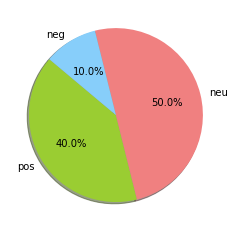

In [20]:
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(text_dict.values(), labels=text_dict.keys(), colors=colors,
   autopct='%1.1f%%', shadow=True, startangle=140)

plt.show()